In [1]:
import sys
# Before using tensorflow:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
import tensorflow.keras.backend as KB
from matplotlib import pylab as plt
import tensorflow.keras
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

import pickle
import numpy as np
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.3.2
Keras Version: 2.4.0

Python 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
GPU is NOT AVAILABLE


## Create the model / CNN architecture

In [2]:
import tensorflow
from client.models.AMLmodel import construct_model
model = construct_model()

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      1184      
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 64)        1

## Train a model usign data

In [9]:
! tar xf dataset/processed/data_partitions/partition0.tar.gz -C dataset/processed/data_partitions/
! tar xf dataset/processed/data_partitions/partition1.tar.gz -C dataset/processed/data_partitions/

In [10]:
import numpy as np
from client.data.datagenerator import DataGenerator

labels0 = np.load('dataset/processed/data_partitions/partition0/labels.npy', allow_pickle=True).item()
data_path0 = 'dataset/processed/data_partitions/partition0/data_singlets'

ids0 = [l for l in labels0]
np.random.shuffle(ids0)
train_split_index = int(len(ids0)*0.9)
train_ids = ids0[:train_split_index]
val_ids = ids0[train_split_index:]

train_gen = DataGenerator(train_ids,labels0, data_path0, dim=(100,100), batch_size=32)
val_gen = DataGenerator(val_ids,labels0, data_path0, dim=(100,100), batch_size=32)

In [11]:
model.fit(train_gen,epochs=20)

Epoch 1/20
17/17 [==============================] - 58s 3s/step - loss: 0.1011 - accuracy: 0.9743
Epoch 2/20
17/17 [==============================] - 59s 3s/step - loss: 0.0838 - accuracy: 0.9779
Epoch 3/20
17/17 [==============================] - 61s 4s/step - loss: 0.0299 - accuracy: 0.9945
Epoch 4/20
17/17 [==============================] - 59s 3s/step - loss: 0.0236 - accuracy: 0.9926
Epoch 5/20
17/17 [==============================] - 59s 3s/step - loss: 0.0152 - accuracy: 0.9982
Epoch 6/20
17/17 [==============================] - 60s 4s/step - loss: 0.0193 - accuracy: 1.0000
Epoch 7/20
17/17 [==============================] - 57s 3s/step - loss: 0.0085 - accuracy: 1.0000
Epoch 8/20
17/17 [==============================] - 58s 3s/step - loss: 0.0094 - accuracy: 1.0000
Epoch 9/20
17/17 [==============================] - 57s 3s/step - loss: 0.0067 - accuracy: 1.0000
Epoch 10/20
17/17 [==============================] - 59s 3s/step - loss: 0.0058 - accuracy: 1.0000
Epoch 11/20
17/17 [

## Model validation - plot a confusion matrix

We reserve partition1 as a validation set 

In [12]:
np.sort([k for k in labels0])

labels1 = np.load('dataset/processed/data_partitions/partition1/labels.npy', allow_pickle=True).item()
data_path1 = 'dataset/processed/data_partitions/partition1/data_singlets'

ids1 = [l for l in labels1]
np.random.shuffle(ids1)

test_gen = DataGenerator(ids1,labels1, data_path1, dim=(100,100), batch_size=32)
labels, preds = test_gen.predict_all(model)

In [13]:
def confusion_matrix(model, data_gen):
    
    labels, preds = data_gen.predict_all(model)

    y_pred = np.argmax(preds,1)
    y_data = np.argmax(labels,1)
    M = np.zeros((16,16))

    for pred_, true_ in zip(y_pred,y_data):
        M[true_,pred_] +=1
    
    M[15,:15] = np.sum(M[:15,:15],0)
    M[:15,15] = np.sum(M[:15,:15],1)
    M[15,15] = np.sum(M[:15,:15])
        
    return M

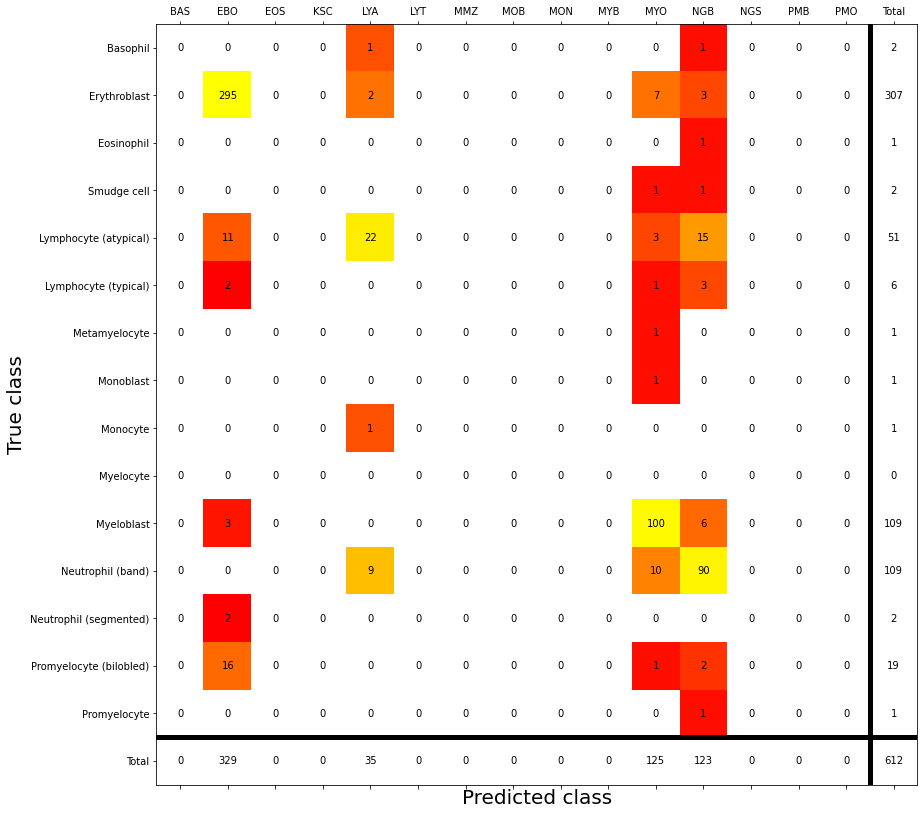

In [14]:
import matplotlib
from client.models.AMLmodel import classes as aml_classes

class_names_y = [aml_classes[k] for k in aml_classes] + ['Total']
class_names_x = [k for k in aml_classes] + ['Total']

def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.autumn):
    
    f, ax = plt.subplots(1,1,figsize=(20,14))
    color_mat = np.zeros(matrix.shape)
    color_mat[:15,:15] = matrix[:15,:15]/np.maximum(1,np.sum(matrix[:15,:15],0))
    ax.matshow(color_mat, cmap=cmap, norm=matplotlib.colors.LogNorm()) 

    tick_mark = np.arange(16)
    ax.set_xticks(tick_mark)
    ax.set_yticks(tick_mark)
    ax.set_xticklabels(class_names_x)
    ax.set_yticklabels(class_names_y)
    
    for (i, j), z in np.ndenumerate(matrix):
        ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')

    ax.axvline(x=14.5,color='black',lw=5)
    ax.axhline(y=14.5,color='black', lw=5)
    ax.set_xlabel('Predicted class', fontsize=20)
    ax.set_ylabel('True class', fontsize=20)

M = confusion_matrix(model, test_gen)
plot_confusion_matrix(M)
plt.savefig('confusion_sample.png')

## Create a model object in Scilifelab Serve 

In [16]:
# We here create a model object in Scilifelab Serve for use with Tensorflow Serving
from stackn import stackn
tf.saved_model.save(model, 'models/1/')
!tar -czvf aml.tar.gz models
stackn.create_object('aml', model_file='aml.tar.gz', release_type="major")

INFO:tensorflow:Assets written to: models/1/assets


01/11/2022 12:36:17 PM [builder_impl.py:774] Assets written to: models/1/assets


models/
models/1/
models/1/assets/
models/1/variables/
models/1/variables/variables.index
models/1/variables/variables.data-00000-of-00001
models/1/saved_model.pb
Released model: aml, release_type: major


True

In [18]:
import stackn.auth as sa
import requests
import numpy as np

# If you are running locally with self signed certificate, then CHANGE the secure and verify variables to False
secure = {"STACKN_SECURE": True}
conf, status = sa.get_token(secure)

# Load image to predict on / form input
imgtest = np.load('dataset/processed/data_partitions/partition0/data_singlets/MON_1683.npy')
imgtest=np.expand_dims(imgtest,0)
inp = {"inputs": imgtest.tolist()}

# You can get this endpoint by serving the model through the Tensorflow Serve App on Scilifelab Serve
endpoint = 'https://r819d68e0.serve-dev.scilifelab.se/v1/models/models:predict'
res = requests.post(endpoint, json=inp, headers={"Authorization": "Bearer "+conf['STACKN_ACCESS_TOKEN']})

Prediction: Lymphocyte (atypical)


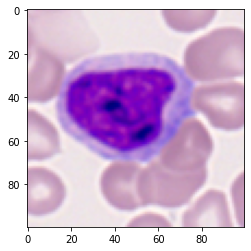

In [20]:
plt.imshow(imgtest[0])
print("Prediction:", class_names_y[np.argmax(res.json()['outputs'])])